# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

1. **Exploración de datos y Procesamiento del Lenguaje Natural**

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

2. **Machine Learning**

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

**Para pensar, investigar y, opcionalmente, implementar**
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

**¡Tómate tiempo para investigar y leer mucho!**

In [2]:
%%time
%colors LightBG
from IPython.display import HTML, SVG
from IPython.display import clear_output
from utils import highlight_regex_matches
from collections import Counter

import itertools
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.diverging_palette(200, 10, as_cmap=True)
sns.set()

import advertools as adv
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer


import os
from platform import python_version
print('Python {}'.format(python_version()))

Python 3.8.8
Wall time: 12 ms


In [5]:
# version libraries
import sklearn
modules = [np, pd, sns, mpl, spacy, nltk, adv, sklearn] # numpy, pandas, seaborn, matplotlib, sklearn
row = '<tr> <td>%s</td> <td>%s</td> </tr>'
rows = '\n'.join([row % (module.__name__, module.__version__) for module in modules])
s = '<table> <tr><th>Library</th><th>Version</th> </tr> %s</table>' % rows
HTML(s)

Library,Version
numpy,1.20.2
pandas,1.2.4
seaborn,0.11.1
matplotlib,3.3.4
spacy,3.0.6
nltk,3.5
advertools,0.11.1
sklearn,0.24.2


In [6]:
# Display options
pd.reset_option("^display") 
pd.set_option('max_columns', 100) 
pd.set_option('max_rows', 80) 
pd.set_option('max_colwidth', 100) 
pd.set_option("precision", 2)
pd.set_option('display.float_format', '{:,.2f}'.format) 

<h1 style="text-align:center;"> Exploring dataset &#x1F4C1;</h1>

In [7]:
# import dataset, concat and shape

# read data - Sequential Recommendation
dataset1 = pd.read_json('dataset/dataset_es_test.json', lines=True, orient='records') # len 5,000
data = pd.read_json('dataset/dataset_es_train.json', lines=True, orient='records') # len 200,000
dataset3 = pd.read_json('dataset/dataset_es_dev.json', lines=True, orient='records') # len 5,000



# concat and reset index Data
#data = pd.concat([dataset1, 
#                  dataset2, 
#                  dataset3
#                 ], axis=0).reset_index(drop=True)

row, col = data.shape
print('Total row:\t {} \nTotal colums:\t {}'.format(row, col))
data.head(3)

Total row:	 200000 
Total colums:	 8


,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8 meses y no he recibido respuesta del fabricante,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ni nosotros que sabemos inglés, ni un informático,...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,"Te obligan a comprar dos unidades y te llega solo una y no hay forma de reclamar, una autentica ...",solo llega una unidad cuando te obligan a comprar dos,es,drugstore


In [8]:
# Column Names, missing values and memory usage
name_col = data.columns.values.tolist()
print('Nombres de las columnas: {} \n '.format(name_col))

#  memory usage of each column
new_mem = data.info(memory_usage='deep')
new_mem

Nombres de las columnas: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'] 
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   review_id         200000 non-null  object
 1   product_id        200000 non-null  object
 2   reviewer_id       200000 non-null  object
 3   stars             200000 non-null  int64 
 4   review_body       200000 non-null  object
 5   review_title      200000 non-null  object
 6   language          200000 non-null  object
 7   product_category  200000 non-null  object
dtypes: int64(1), object(7)
memory usage: 126.1 MB


In [9]:
# Total stars by review body
total_stars = data.groupby(['stars'], as_index=False)['review_body'].count()

for star in total_stars['stars']:
    total_stars.loc[star-1,'stars'] = '\U00002B50' * star
total_stars.sort_values('stars', ascending=False, ignore_index=True)

,stars,review_body
0,⭐⭐⭐⭐⭐,40000
1,⭐⭐⭐⭐,40000
2,⭐⭐⭐,40000
3,⭐⭐,40000
4,⭐,40000


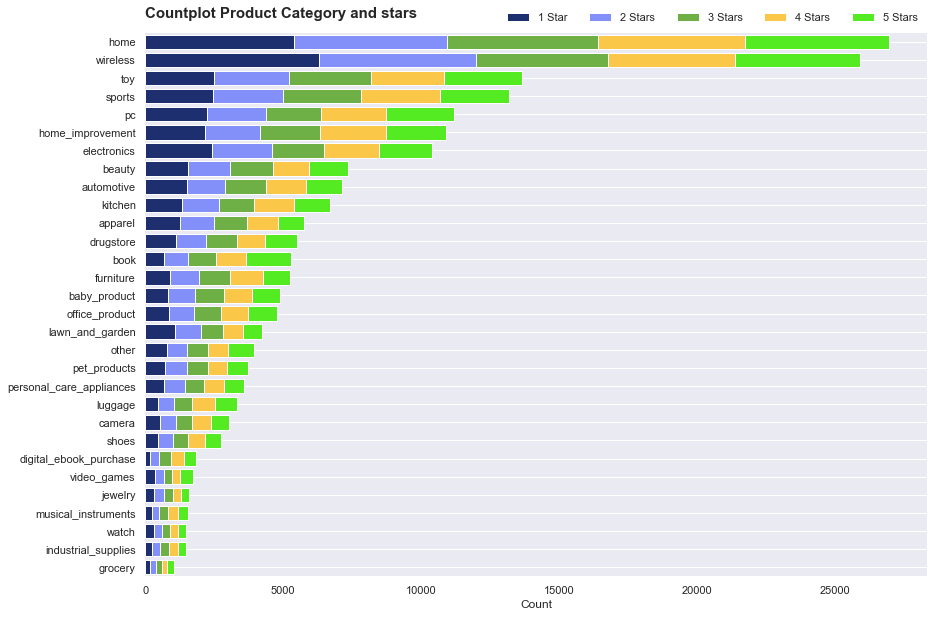

In [10]:
# Total stars by product category

# df_groupe for stacked bar plot
df_grouped_produc2 = data.groupby(['product_category', 'stars'])['product_category'].count().astype(int)\
        .unstack('stars').add_suffix('_stars')

df_grouped_produc2['Total'] = df_grouped_produc2.sum(axis=1)
df_grouped_produc2 = df_grouped_produc2.sort_values('Total')

# stacked bar plot
fields = ['1_stars', '2_stars', '3_stars', '4_stars', '5_stars']
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748', '#55eb23']
labels = ['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']

# figure and axis
fig, ax = plt.subplots(1, figsize=(14, 10))
# plot bars
left = len(df_grouped_produc2) * [0]
for idx, name in enumerate(fields):
    plt.barh(df_grouped_produc2.index, df_grouped_produc2[name], left = left, color=colors[idx])
    left = left + df_grouped_produc2[name]
    
# title, legend, labels
plt.title('Countplot Product Category and stars', loc='left', fontsize=15, fontweight='bold', pad= 15)
plt.legend(labels, bbox_to_anchor=([0.45, 1, 0, 0]), ncol=5, frameon=False)
plt.xlabel('Count')

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

In [11]:
# Extract id number of the columns
def extract_num(val):
    for i in val:
        val = re.sub(r'[^0-9]', r'', val)
    return val

# Extrac id
data['review_id'] = data['review_id'].apply(extract_num).astype(np.int32)
data['product_id'] = data['product_id'].apply(extract_num).astype(np.int32)
data['reviewer_id'] = data['reviewer_id'].apply(extract_num).astype(np.int32)

# Change dtype column 'stars'
data['stars'] = data['stars'].astype(np.int8)


data.head(3)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,491108,296024,999081,1,Nada bueno se me fue ka pantalla en menos de 8 meses y no he recibido respuesta del fabricante,television Nevir,es,electronics
1,869872,922286,216771,1,"Horrible, nos tuvimos que comprar otro porque ni nosotros que sabemos inglés, ni un informático,...",Dinero tirado a la basura con esta compra,es,electronics
2,811721,474543,929213,1,"Te obligan a comprar dos unidades y te llega solo una y no hay forma de reclamar, una autentica ...",solo llega una unidad cuando te obligan a comprar dos,es,drugstore


<h1 style="text-align:center;">Preprocessing and Understanding Text &#x2699;&#xFE0F;</h1>

In [12]:
# Copy Dataframe
df = data.copy()

<h2>Data Wrangling &#x1F920;</h2>

<h3>Clean Uppercase and non-alphanum &#x1F520; &#x1F523;</h3> 

In [13]:
# Check non-alphanum
from utils import highlight_regex_matches

# Example 
pattern = re.compile(r'(?x)[\\!@#$&*~+_?/<>:;-]\s*')

non_alphanum_body = df[df['review_body'].str.contains(pattern)]
clear_output()

In [14]:
# Random regex matches text
index_random = np.random.choice(list(non_alphanum_body.index.values))
Original_text = df.loc[index_random].review_body

highlight_regex_matches(pattern, Original_text)

Los otros productos d ela misma firma han resultado muy buenos sin embargo el limpiador escuece a los ojos y no es nada práctico. No repetiré!


In [15]:
# count all-capital letters per review_body
upper_review_body = df[df['review_body'].str.isupper()]
print('Total rows with all-capital letters in review body: {}'.format(len(upper_review_body)))

Total rows with all-capital letters in review body: 1914


<p>Clean 🛠️</p>

In [16]:
# Cleaning text non-alphanum
def clean_non_alphanum(df, col):
    col_clean = list(df[col])
    for i in range(len(col_clean)):
        
        # FULL STOP 0R PERIOD = 'hello...  Python' or 'hello  ...Python' = hello. Python
        col_clean[i] = re.sub(r'\s(\,|\.|\!)\s', r'\1 ', col_clean[i])
        col_clean[i] = re.sub('\s+\.+|\.+\s+', '. ', col_clean[i])  
        
        # SPECIAL_CHARS = '\s+|#|\+' = ''
        col_clean[i] = re.sub(r'(\W)\1+|#|\+|\~|\_|\*|\s+',r'\1 ', col_clean[i]) # pendiente usear: (?x)[!@#$&*~+_]\s*
        col_clean[i] = re.sub(r'(?<=\,|\.)(\W+)', r' ', col_clean[i]) # 'hola,  python' = 'hola, python'
        
        # UPPER CASE
        upper_sent = re.findall(r'\w(?=[A-Z])[A-Z]+', col_clean[i])
        if len(upper_sent) >= 4 or col_clean[i].isupper() == True:
            # 'HELLO.PYTHON' = 'HELLO. PYTHON'
            col_clean[i] = ' '.join(e for e in re.split('(?<=[A-Z]\.)(?=[A-Z])', col_clean[i]))
            # 'HELLO. PYTHON' = 'Hello. Python'
            col_clean[i] = '. '.join(e.capitalize() for e in re.split('\.\s', col_clean[i]))       
        else:
            # 'Hello.Word' = 'Hello. Word'
            col_clean[i] = ' '.join(e for e in re.split('(?<=\w)\.(?=[a-z])', col_clean[i]))
            col_clean[i] = re.sub(r'(?<=\w)\.+(?=[a-z])', ', ', col_clean[i])
            col_clean[i] = ' '.join(e for e in re.split('(?<=\.)(?=[a-zA-Z])', col_clean[i]))
        
        # Normalization first capital word in a sentences
        match = re.findall(r'(?<=\b)\.\s[\w]+', col_clean[i])
        if len(match) >= 1: 
            #match = '. python' = '. Python'
            for m in range(len(match)):
                col_clean[i] = col_clean[i].replace(match[m],('. '+match[m][2:].capitalize()))
    
    return col_clean

# clean text
%time df['review_body'] = clean_non_alphanum(df,'review_body')

Wall time: 29.7 s


In [17]:
# Check if you have Uppercase
upper_review_body = df[df['review_body'].str.isupper()]
print('Total rows with all-capital letters in review body: {}'.format(len(upper_review_body)))

Total rows with all-capital letters in review body: 0


<h3>Clean Emoji &#x26a0;&#xfe0f;</h2>

In [18]:
# Total emojis in column reviwe_body by rows

# Advertools
emoji_compile = adv.emoji.EMOJI


# Extracting strings.
p = emoji_compile
def matcher(x):
    f = p.findall(x)
    if f:
        return f
    return None

# extract emoji
def extract_emoji(df, col):
    emoji = pd.Series([matcher(x) for x in df[col]])
    emoji_count = [len(em) if em != None else em for em in emoji]
    emoji_text = [' '.join(em) if em != None else em for em in emoji]
    sumary = {
        'emoji': emoji,
        'emoji_text': emoji_text,
        'emoji_counts': emoji_count        
    }
    return sumary

%time emoji = extract_emoji(df, 'review_body')

Wall time: 7min 27s


In [19]:
# df Emojis
df_emoji_body = pd.DataFrame(data=emoji).drop(columns='emoji').sort_values(by='emoji_counts', ascending=False).dropna()

print('Total post with emojis: {}'.format(len(df_emoji_body)))
print('Total emojis: {}'.format(sum(df_emoji_body['emoji_counts'])))

df_emoji_body.head(10)

Total post with emojis: 600
Total emojis: 641.0


,emoji_text,emoji_counts
117710,👏 👏 👏 👏 👏 👏,6.00
197410,⭐ ⭐ ⭐ ⭐ ⭐,5.00
108822,👏🏻 👏🏻 👏🏻 👏🏻,4.00
33911,👎🏻 👎🏻 👎🏻 👎🏻,4.00
164816,😉 😉 😉,3.00
38791,😂 😂 😂,3.00
108518,☺ ☺ ☺,3.00
169234,👍🏼 👍🏼,2.00
127488,👌🏼 🎮,2.00
144307,💩 😅,2.00


In [20]:
# Add space between emojies
p = emoji_compile
def add_space_between_emojies(text):
    '''
    >>> add_space_between_emojies('Python is fun 💚')
    'Python is fun '    
    '''
    text = re.sub(p, r'', text)
    return text

# add space between emojies
%time df['review_body'] = pd.Series([add_space_between_emojies(x) for x in df.review_body])

Wall time: 7min 46s


In [21]:
# Export Dataframe CSV.
from io import StringIO
import sys

fout = StringIO()
df.to_csv('./dataset/df_clean_emoji', index=False)
print('\U0001F680')

🚀


<h2>Pre-Processing</h2>

In [22]:
# read csv
data2 = pd.read_csv('df_clean_emoji')

In [23]:
# selecting columns
df_col = ['review_body',
          'stars',
            #'review_title',
            #'product_category'
]
columns_name = {'review_body':'Review','stars':'Sentiment'}
df = data2[df_col].rename(columns_name, axis=1)

<h3>Text Correction</h3>

In [24]:
# Example 
pattern = re.compile(r'(?<=\s)100%(?=\s)')
#pattern = re.compile(r'(?<=\s)[A-Z]{3,}(?=\s)')
#1 (?<=\s)xq|pq(?=\s) --> xq, pq "replece" -- 'porque'
#2 (?<=\w\w)(?=\q\s) --> loq, aunq, asiq "split" -- ' que'
#3 (?<=\s)q(?=\s) --> q 'replece' -- 'que'
#4 (?<=\s)x(?=\s) --> x 'replace' -- 'por'

non_alphanum_body = df[df['Review'].str.contains(pattern)]
non_alphanum_body
print(f'Total rows with wrong words:',len(non_alphanum_body))

# Random regex matches text
index_random = np.random.choice(list(non_alphanum_body.index.values))
Original_text = non_alphanum_body.loc[index_random].Review

highlight_regex_matches(pattern, Original_text)

Total rows with wrong words: 706
El producto es tal cual se ve en la foto! La mayoria de mis aretes y anillos son grandes y todo cabe perfectamente 100% recomendado


In [25]:
# Replace wrong words
df['Review'] = df['Review'].replace(regex={r'(?<=\s)xq|pq(?=\s)':'porqué'})
df['Review'] = df['Review'].replace(regex={r'(?<=\s)q(?=\s)':'que'})
df['Review'] = df['Review'].replace(regex={r'(?<=\s)x(?=\s)':'por'})
df['Review'] = df['Review'].replace(regex={r'(?<=\s)k(?=\s)':'que'})
df['Review'] = df['Review'].replace(regex={r'(?<=\s)ke(?=\s)':'que'})
df['Review'] = df['Review'].replace(regex={r'(?<=\s)echo(?=\s)':'hecho'})
df['Review'] = df['Review'].replace(regex={r'(?<=\s)halla(?=\s)':'haya'})
df['Review'] = df['Review'].replace(regex={r'(?<=\s)ay(?=\s)':'hay'})

In [26]:
# Explored random review body
index_random = np.random.randint(0, high=df.shape[0])
index_x = 209795
titular = df.iloc[index_random].Review
print('Number index: {} \nReview: {}\nSentiment: {}'.format(index_random, titular, df.iloc[index_random].Sentiment))

Number index: 196913 
Review: Mochila muy robusta que en este color gris, no tiene un aspecto demasiado táctico, lo que para mi es un plus. Muy bien pensada y terminada en sus acabados. Recomendable.
Sentiment: 5


In [27]:
# Example Correct Spelling
from autocorrect import Speller
spell = Speller(only_replacements=True, lang='es')

def correct_spelling(tokens):
    sentence_corrected = [spell(word) for word in tokens]
    return sentence_corrected

print('Number index: {} \nReview: {}\nSentiment: {}'.format(index_random, spell(titular), df.iloc[index_random].Sentiment))


dictionary for this language not found, downloading...
__________________________________________________
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
done!
Number index: 196913 
Review: Mochila muy robusta que en este color gris, no tiene un aspecto demasiado táctico, lo que para mi es un plus. Muy bien pensada y terminada en sus acabados. Recomendable.
Sentiment: 5


<h3>Text Tokenization</h3>

In [28]:
# Load trained model and pipeline 
nlp = spacy.load("es_core_news_md")

#-------------
# name of the model and version
print('Name model and version: {}_{}, V. {}'.format(nlp.meta['lang'],nlp.meta['name'],nlp.meta['version'])) 
print()
# list of pipeline componets used with the model
print(f'Pilene components:',nlp.meta['pipeline'])
#------------


# token 
doc = nlp(titular)

Name model and version: es_core_news_md, V. 3.0.0

Pilene components: ['tok2vec', 'morphologizer', 'parser', 'ner', 'attribute_ruler', 'lemmatizer']


In [29]:
# find its location model in your system
spacy.util.get_package_path('es_core_news_md')

WindowsPath('C:/Users/Jackson/anaconda3/envs/nlp-env/lib/site-packages/es_core_news_md')

In [30]:
# Tokenization review
tokens_review = [token.text for token in doc]
print(tokens_review)

['Mochila', 'muy', 'robusta', 'que', 'en', 'este', 'color', 'gris', ',', 'no', 'tiene', 'un', 'aspecto', 'demasiado', 'táctico', ',', 'lo', 'que', 'para', 'mi', 'es', 'un', 'plus', '.', 'Muy', 'bien', 'pensada', 'y', 'terminada', 'en', 'sus', 'acabados', '.', 'Recomendable', '.']


<h3>Sentence Tokenization</h3>

In [31]:
# tokenized sentences
review_sentences = [sent.text for sent in doc.sents]
#for sent in doc.sents:
#    print([sent.text])
print('Total sentences in Review:', len(review_sentences))
print(f'Review text sentences : ', np.array(review_sentences ))

Total sentences in Review: 3
Review text sentences :  ['Mochila muy robusta que en este color gris, no tiene un aspecto demasiado táctico, lo que para mi es un plus.'
 'Muy bien pensada y terminada en sus acabados.' 'Recomendable.']


In [32]:
# separate a text into its individual sentences
for sent in doc.sents:
    print([sent[i] for i in range(len(sent))])

[Mochila, muy, robusta, que, en, este, color, gris, ,, no, tiene, un, aspecto, demasiado, táctico, ,, lo, que, para, mi, es, un, plus, .]
[Muy, bien, pensada, y, terminada, en, sus, acabados, .]
[Recomendable, .]


In [33]:
# tokens in a multi-sentence text
print([doc[i] for i in range(len(doc))])

[Mochila, muy, robusta, que, en, este, color, gris, ,, no, tiene, un, aspecto, demasiado, táctico, ,, lo, que, para, mi, es, un, plus, ., Muy, bien, pensada, y, terminada, en, sus, acabados, ., Recomendable, .]


<H2>Understanding Text Syntax and Structure</H2>

<h3>Parts-of-Speech (PoS) tagging</h3>

In [34]:
# Token attributes (tagging)
# List attributes: https://spacy.io/api/token#attributes
# Universal POS tags: https://universaldependencies.org/docs/u/pos/
# Morphology: https://universaldependencies.org/format.html#morphological-annotation
spacy_pos_tagged = [(word, 
                     word.lemma_, 
                     word.pos_, 
                     word.tag_, 
                     word.dep_, 
                     word.shape_, 
                     word.is_alpha, 
                     word.is_stop, 
                     word.is_digit,
                     spacy.explain(word.tag_)
                    ) for word in doc
                   ]
columns_name = ['Word','Lemma','POS tag','Tag', 'Dep','Shape','Alpha','Stop','Digit','Explain']
df_attributes = pd.DataFrame(spacy_pos_tagged, columns=columns_name).T
df_attributes

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
Word,Mochila,muy,robusta,que,en,este,color,gris,",",no,tiene,un,aspecto,demasiado,táctico,",",lo,que,para,mi,es,un,plus,.,Muy,bien,pensada,y,terminada,en,sus,acabados,.,Recomendable,.
Lemma,Mochila,mucho,robusta,que,en,este,color,gris,",",no,tener,uno,aspecto,demasiado,táctico,",",él,que,para,mi,ser,uno,plus,.,mucho,bien,pensado,y,terminado,en,su,acabado,.,recomendable,.
POS tag,PROPN,ADV,ADJ,SCONJ,ADP,DET,NOUN,ADJ,PUNCT,ADV,VERB,DET,NOUN,ADV,ADJ,PUNCT,PRON,PRON,ADP,DET,AUX,DET,NOUN,PUNCT,ADV,ADV,ADJ,CCONJ,ADJ,ADP,DET,NOUN,PUNCT,ADJ,PUNCT
Tag,PROPN,ADV,ADJ,SCONJ,ADP,DET,NOUN,ADJ,PUNCT,ADV,VERB,DET,NOUN,ADV,ADJ,PUNCT,PRON,PRON,ADP,DET,AUX,DET,NOUN,PUNCT,ADV,ADV,ADJ,CCONJ,ADJ,ADP,DET,NOUN,PUNCT,ADJ,PUNCT
Dep,nsubj,advmod,amod,mark,case,det,nmod,amod,punct,advmod,ROOT,det,obj,advmod,amod,punct,det,nsubj,case,obl,cop,det,advcl,punct,advmod,advmod,ROOT,cc,conj,case,det,obl,punct,ROOT,punct
Shape,Xxxxx,xxx,xxxx,xxx,xx,xxxx,xxxx,xxxx,",",xx,xxxx,xx,xxxx,xxxx,xxxx,",",xx,xxx,xxxx,xx,xx,xx,xxxx,.,Xxx,xxxx,xxxx,x,xxxx,xx,xxx,xxxx,.,Xxxxx,.
Alpha,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,False,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,False,True,False
Stop,False,True,False,True,True,True,False,False,False,True,True,True,False,True,False,False,True,True,True,True,True,True,False,False,True,True,False,False,False,True,True,False,False,False,False
Digit,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Explain,proper noun,adverb,adjective,subordinating conjunction,adposition,determiner,noun,adjective,punctuation,adverb,verb,determiner,noun,adverb,adjective,punctuation,pronoun,pronoun,adposition,determiner,auxiliary,determiner,noun,punctuation,adverb,adverb,adjective,coordinating conjunction,adjective,adposition,determiner,noun,punctuation,adjective,punctuation


<h3>Visualizing the dependency parse</h3>

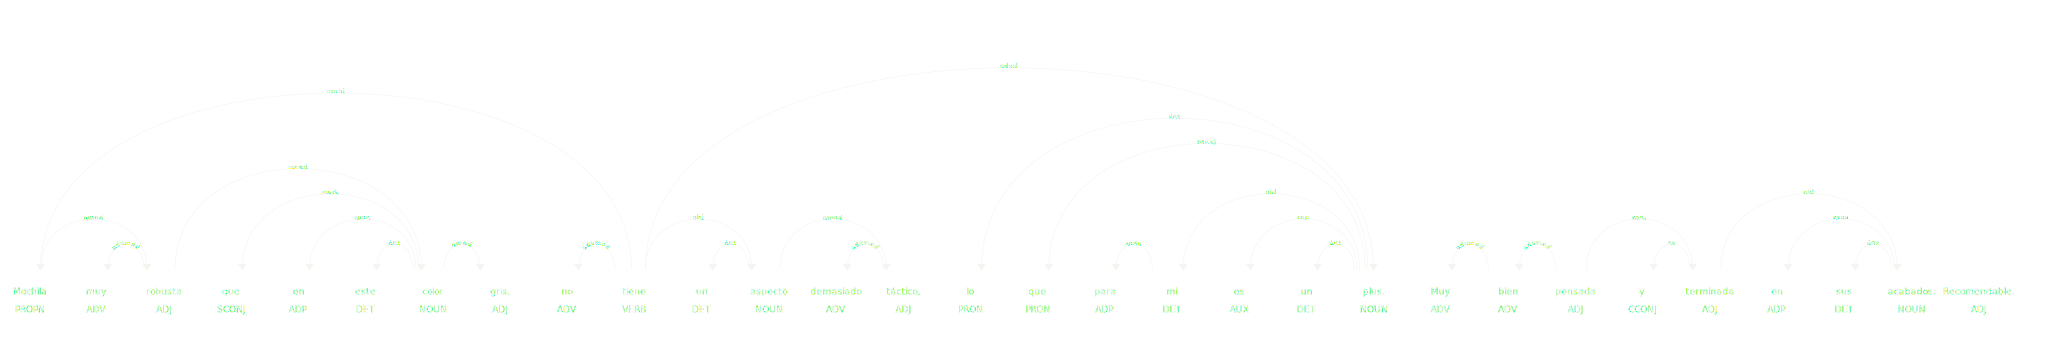

In [35]:
# Visualizing the dependency parse
# https://universaldependencies.org/u/dep/index.html
# https://explosion.ai/demos/displacy/.
from spacy import displacy
from pathlib import Path

options = {'compact':False, "color":'#f5f4f0', 
           'font':'inherit', 'arrow_stroke':1, 
           'distance':120, 'bg':'#2f3029'}
svg = displacy.render(doc, style='dep', options=options, jupyter=False)  # doc.sents
#displacy.serve(doc.sents, style='dep', options=options, host='localhost') # http://localhost:5000

output_path = Path("./images/dependency_plot.svg") # you can keep there only "dependency_plot.svg" if you want to save it in the same folder where you run the script 
output_path.open("w", encoding="utf-8").write(svg)

SVG(filename='./images/dependency_plot.svg')

<h3> Semantic Analysis</h3>

In [36]:
# Print words assigned to attribute
print('Number index: {} \nReview body: {}\nStars: {}\n'.format(index_random, titular, df.iloc[index_random].Sentiment))
print('Verb and Adj:{}\n'.format([w.text for w in doc if w.pos_== 'VERB' or w.pos_== 'ADJ']))
print('Adv, Det & Noun:{}\n'.format([w.text for w in doc if w.pos_ == 'ADV' or w.pos_ =='DET' or w.pos_ == 'NOUN']))
print('Adv & Adj:{}'.format([w.text for w in doc if w.pos_ == 'ADV' or w.pos_ == 'ADJ']))

Number index: 196913 
Review body: Mochila muy robusta que en este color gris, no tiene un aspecto demasiado táctico, lo que para mi es un plus. Muy bien pensada y terminada en sus acabados. Recomendable.
Stars: 5

Verb and Adj:['robusta', 'gris', 'tiene', 'táctico', 'pensada', 'terminada', 'Recomendable']

Adv, Det & Noun:['muy', 'este', 'color', 'no', 'un', 'aspecto', 'demasiado', 'mi', 'un', 'plus', 'Muy', 'bien', 'sus', 'acabados']

Adv & Adj:['muy', 'robusta', 'gris', 'no', 'demasiado', 'táctico', 'Muy', 'bien', 'pensada', 'terminada', 'Recomendable']


In [37]:
# list of potential keywords for each sentence based on specific dependency labels
for sent in doc.sents:
    print([w.text for w in sent if w.dep_ == 'advmod' or w.dep_ == 'csubj'])

['muy', 'no', 'demasiado']
['Muy', 'bien']
[]


**The doc.noun_chunks Container**

Sustantivo con su nucleo (noun as its head)

In [38]:
# extract noun chunks by iterating over the nouns in the \
# sentence and finding the syntactic children for each noun to form a chunk.
for token in doc:
    if token.pos_=='NOUN':
        chunk = ''
        for w in token.children: # for w in token.lefts:
            if w.pos_ == 'DET' or w.pos_ == 'ADJ':
                chunk = chunk + w.text + ' '
                chunk = chunk + token.text
                print(chunk)

este color
este colorgris color
un aspecto
un aspectotáctico aspecto
mi plus
mi plusun plus
sus acabados


<h3>Stop Words</h3>

In [41]:
# total stop word spacy
spacy_stopwords = nlp.Defaults.stop_words
nltk_stopwords = stopwords.words('spanish')

# Removing Stop Words from Default SpaCy Stop Words List
nlp.vocab["no"].is_stop = False
nlp.vocab["pero"].is_stop = False
nlp.vocab['él'].is_stop = True



print(f'Total stop word Spacy: {len(spacy_stopwords)}')
print(f'Total stop word Nltk: {len(nltk_stopwords)}')

# Adding Stop Words to Default SpaCy Stop Words List
#spacy_stopwords.add("él")
#spacy_stopwords |= {"likes","tennis",}

# Removing Stop Words from Default SpaCy Stop Words List
# spacy_stopwords.remove('likes')
# spacy_stopwords -= {"whatever", "whenever"}

# My stopwords list
my_stopword = set(nltk_stopwords).union(set(spacy_stopwords))
my_stopword.remove('pero')
print(f'Total stop word My stopwords: {len(my_stopword)}')

# Example
#sentence = nlp("no él is definitelynotastopword")
#sentence[1].is_stop

Total stop word Spacy: 551
Total stop word Nltk: 313
Total stop word My stopwords: 703


In [42]:
# Remove stopwords
reveiw_stopwords = [token for token in doc if not token.is_stop and not token.is_punct]
print(reveiw_stopwords)

[Mochila, robusta, color, gris, no, aspecto, táctico, plus, pensada, y, terminada, acabados, Recomendable]


<h2>Frequency distributions of tokens in text</h2>

In [43]:
# Pre-proccesing


# cleaning
def remove_special_characters(corpus, keep_list=[]):
    cleaned_corpus = pd.Series([],dtype=pd.StringDtype())
    for row in corpus:
        qs = []
        for word in row.split():
            if word not in keep_list:
                # '(?x)(?=[^\d\.])\W+' - '[\W+\d+]+
                pattern = r'(?x)(?=[^\d\.])\W+'
                p1 = re.sub(pattern, repl=' ',string=word, flags=re.U)
                p1 = p1.lower()
                p1 = p1.strip()
                qs.append(p1)
            else : qs.append(word)
        cleaned_corpus = cleaned_corpus.append(pd.Series(' '.join(qs)))
    return cleaned_corpus

# Stopwords Removal
def stopwords_removal(corpus, remove_digits=False, stopwords=[], word_len=1):    
    # Removing Stop Words from Default SpaCy Stop Words List
    rmv_words = ['no']
    # list or dict stopwords
    stop = set(stopwords)
    for word in rmv_words:
        nlp.vocab[word].is_stop = False
    if remove_digits:
        corpus = [[x.text for x in nlp(x) if x.text not in stop 
                   and not len(x.text)<word_len+1 and not x.is_digit] for x in corpus]
    else:
        corpus = [[x.text for x in nlp(x) if x.text not in stop 
                   and not len(x.text)<word_len+1] for x in corpus]
    corpus = [' '.join(x) for x in corpus]
    return corpus  

# lemmatization
def lemmatize(corpus):
    corpus = [[x.lemma_ for x in nlp(x)] for x in corpus]
    return corpus

# Stemming
def stem(corpus):
    corpus = [' '.join(x) for x in corpus] 
    stemmer = SnowballStemmer(language = 'spanish')
    corpus = [[stemmer.stem(x) for x in x.split()] for x in corpus]
    return corpus

# funcion
def normalize_text(corpus, keep_list=[], cleaning = True, 
                   stemming = False, lemmatization = False, 
                   remove_stopwords = True, remove_digits=False, stop_words=spacy_stopwords, word_len=0):
    '''    
    Parameters
    ------------
    corpus: pd.Series()
        Text corpus on which pre-processing tasks will be performed
        
    cleanning : bool = True
        keep_list : list[str]
        List of words to be retained during cleaning process  
        
    stemming : bool = False
        Snowball Stemmer
        
    lemmatization: bool = False
    
    remove_stopwords = bool = True
        remove_digits = bool = True
        stopwords= list[spacy_stopwords, nltk_stopwords, my_stopword] = spacy_stopwords
        word_len = int = 3
    
    Note : Either stemming or lemmatization should be used. There's no benefit of using both of them together
    
    Output : Returns the processed text corpus
    
    '''
    
    if cleaning == True:
        corpus = remove_special_characters(corpus, keep_list)
    
    if remove_stopwords == True:
        corpus = stopwords_removal(corpus, remove_digits, stop_words, word_len)
    else:
        pass
    
    if lemmatization == True:
        corpus = lemmatize(corpus)
    else:
        corpus = [[x for x in x.split()] for x in corpus]
        
    if stemming == True:
        corpus = stem(corpus)

    corpus = [' '.join(x) for x in corpus]
    
    return corpus

In [44]:
# Serie object from dataframe
review_text = pd.Series(df.Review.tolist())

In [45]:
#preprocessing with lemmatization 
df_sl = normalize_text(review_text, cleaning=True,
                       lemmatization=True,
                       remove_stopwords=True, remove_digits=True, 
                       word_len=3, stop_words=my_stopword)

In [46]:
# view sample data
df['review_stop_lemma'] = df_sl
df = df[['review_stop_lemma', 'Review', 'Sentiment']]
df.head(3)

,review_stop_lemma,Review,Sentiment
0,pantalla mes recibido respuesta fabricante,Nada bueno se me fue ka pantalla en menos de 8 meses y no he recibido respuesta del fabricante,1
1,horrible comprar inglés informático hora capaz instalar él,"Horrible, nos tuvimos que comprar otro porque ni nosotros que sabemos inglés, ni un informático,...",1
2,obligar comprar unidad llegar forma reclamar autentico estafa compreis,"Te obligan a comprar dos unidades y te llega solo una y no hay forma de reclamar, una autentica ...",1


In [47]:
# Export df preprocessing
df.to_csv('dataset/df_freq_stop_lemma.csv', index=False)

<h3>Visualising Frequency distributions of token per Review-stars</h3>

In [48]:
# the removal of all occurrences of a given item using list comprehension
def remove_items(test_list, item):
    # using list comprehension to perform the task
    res = [i for i in test_list if i != item]
    return res

# plot Frequency distribution
def plot_freqdist_freq(fd, max_num=None, cumulative=False,
                       title='Frequency plot',
                       linewidth=2):
    tmp = fd.copy()
    norm = fd.N()
    for key in tmp.keys():
        tmp[key] = float(fd[key]) / norm

    if max_num:
        tmp.plot(max_num, cumulative=cumulative,
                 title=title, linewidth=linewidth)
    else:
        tmp.plot(cumulative=cumulative,
                 title=title,
                 linewidth=linewidth)

    return

In [49]:
# Frequency distributions of tokens in text
review_one_star = df[df['Sentiment']==1].review_stop_lemma
token_one = ' '.join(review_one_star).split()
token_one = remove_items(token_one, item='él')
freq_one = FreqDist(token_one)

review_two_star = df[df['Sentiment']==2].review_stop_lemma
token_two = ' '.join(review_two_star).split()
token_two = remove_items(token_two, item='él')
freq_two = FreqDist(token_two)

review_three_star = df[df['Sentiment']==3].review_stop_lemma
token_three = ' '.join(review_three_star).split()
token_three = remove_items(token_three, item='él')
freq_three = FreqDist(token_three)

review_four_star = df[df['Sentiment']==4].review_stop_lemma
token_four = ' '.join(review_four_star).split()
token_four = remove_items(token_four, item='él')
freq_four = FreqDist(token_four)

review_five_star = df[df['Sentiment']==5].review_stop_lemma
token_five = ' '.join(review_five_star).split()
token_five = remove_items(token_five, item='él')
freq_five = FreqDist(token_five)

# Frequency all df_sl
all_token_review = ' '.join(df_sl).split()
all_token_review = remove_items(all_token_review, item='él')
freq_all_df_sl = FreqDist(all_token_review)

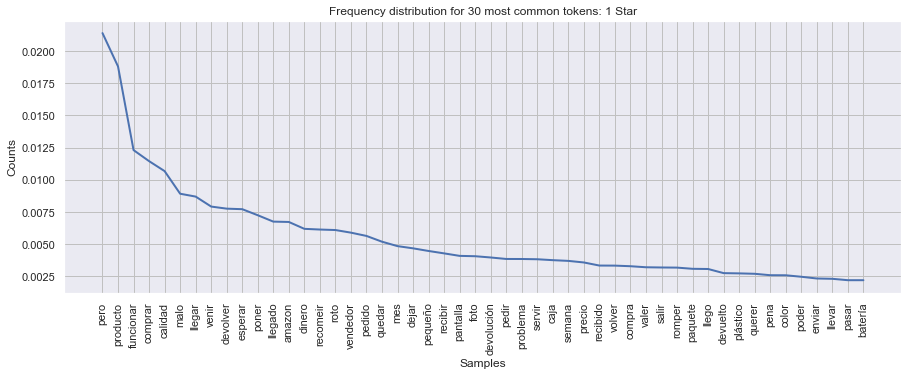

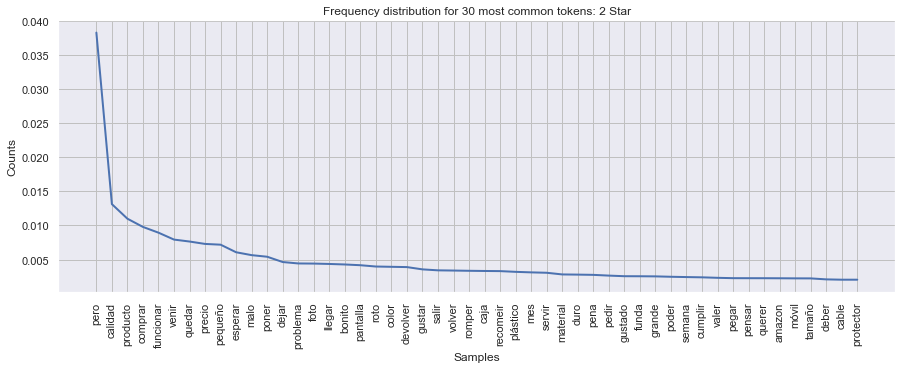

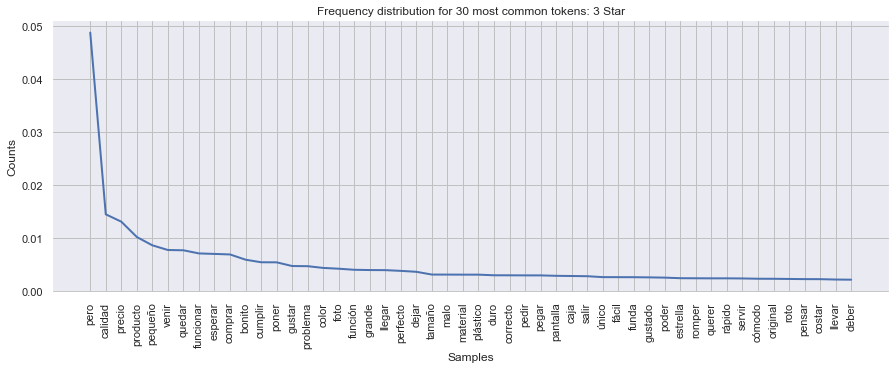

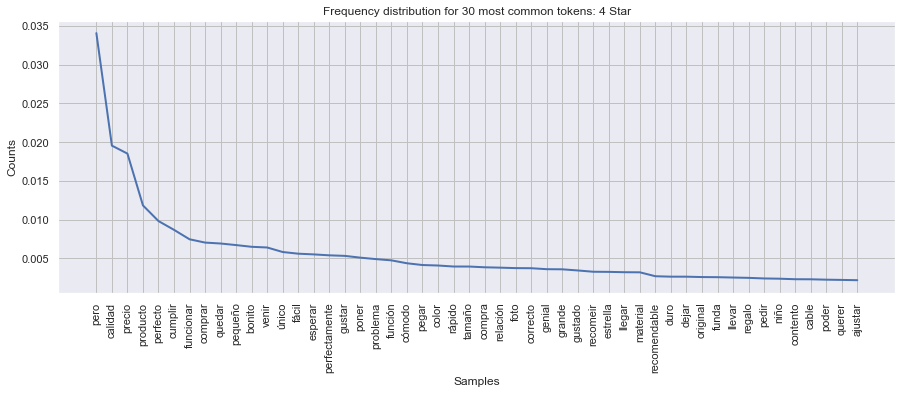

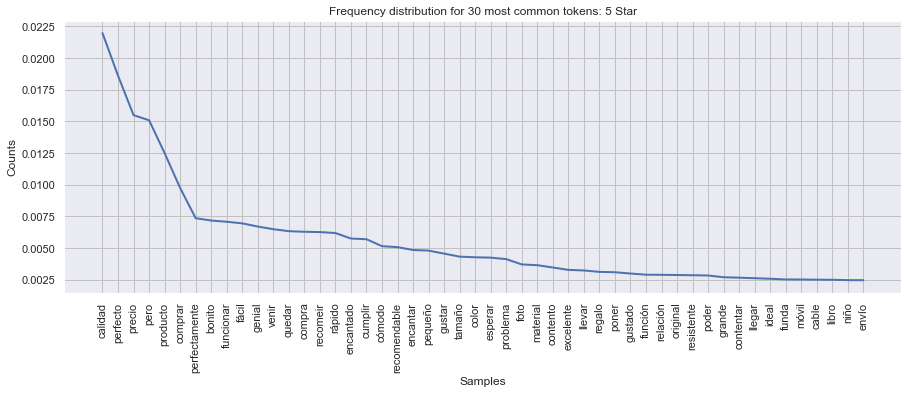

In [50]:
# Visualising Frequency distributions

fig, ax = plt.subplots(figsize=(15,5))
plot_freqdist_freq(freq_one, max_num=50, title='Frequency distribution for 30 most common tokens: 1 Star', linewidth=2)

fig, ax = plt.subplots(figsize=(15,5))
plot_freqdist_freq(freq_two, max_num=50, title='Frequency distribution for 30 most common tokens: 2 Star', linewidth=2)

fig, ax = plt.subplots(figsize=(15,5))
plot_freqdist_freq(freq_three, max_num=50, title='Frequency distribution for 30 most common tokens: 3 Star', linewidth=2)

fig, ax = plt.subplots(figsize=(15,5))
plot_freqdist_freq(freq_four, max_num=50, title='Frequency distribution for 30 most common tokens: 4 Star', linewidth=2)

fig, ax = plt.subplots(figsize=(15,5))
plot_freqdist_freq(freq_five, max_num=50, title='Frequency distribution for 30 most common tokens: 5 Star', linewidth=2)

<h3>Visualising Frequency distributions of token of token in dataframe</h3>

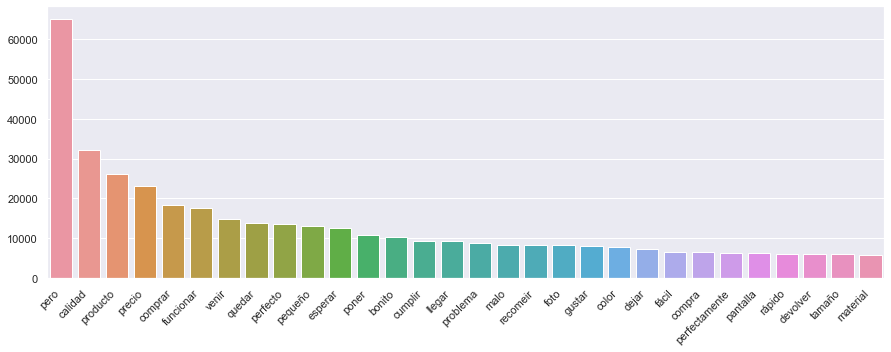

In [51]:
## Conversion to Pandas series via Python Dictionary for easier plotting


all_fdist = pd.Series(dict(freq_all_df_sl)).sort_values(ascending=False).iloc[:30]
# pd.DataFrame.from_dict(freq_one.items()).rename()

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(15,5))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation = 45, ha='right', x=1)

plt.show()

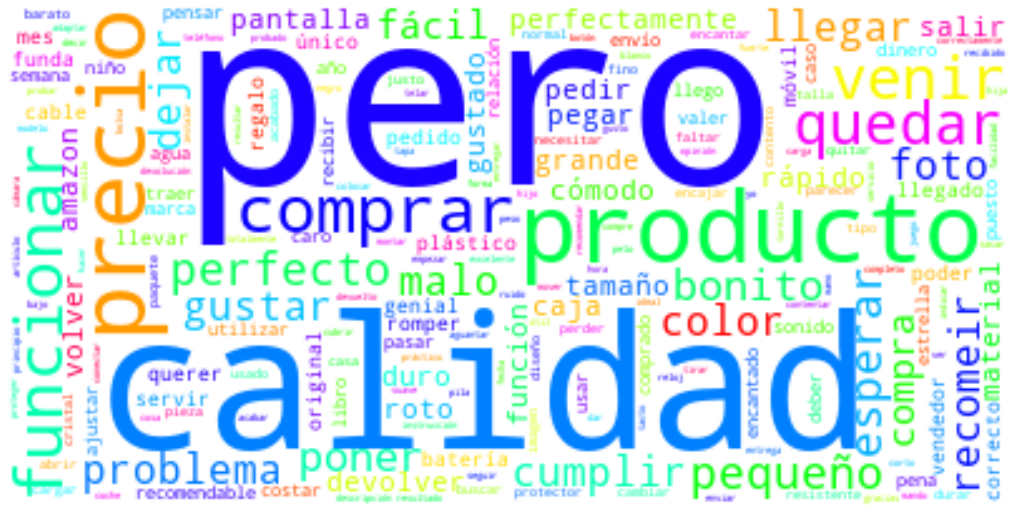

In [53]:
# Visualising Frequency with WordCloud
from collections import Counter
from wordcloud import WordCloud

cloud = WordCloud(max_font_size=100,
                  max_words=200, 
                  background_color='white', 
                  colormap="hsv").generate_from_frequencies(frequencies=freq_all_df_sl)

plt.figure(figsize=(18,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Save the image in the img folder:
cloud.to_file("./images/cloud_review_df_s1.png")

In [54]:
df_one_star = pd.DataFrame(list(freq_one.items()), 
                           columns = ["Word","Frequency"])\
                                .sort_values('Frequency', 
                                         ascending=False).reset_index(drop=True)
df_one_star.head()

,Word,Frequency
0,pero,8735
1,producto,7678
2,funcionar,5026
3,comprar,4676
4,calidad,4360


<h1>Text Classification</h1>

In [55]:
# copy dataframe
data3 = data.copy()

# selecting columns
col_df = ['review_body',
            'stars',
            #'review_title',
            #'product_category'
]
columns_name = {'review_body':'review','stars':'sentiment'}
data3 = data3[col_df].rename(columns_name, axis=1)

In [56]:
# Load trained model and pipeline 
nlp = spacy.load("es_core_news_md", 
                 #disable=['parser']
                ) # Disabling the parser will make spaCy load and run much faster

#-------------
# name of the model and version
print('Name model and version: {}_{}, V. {}'.format(nlp.meta['lang'],nlp.meta['name'],nlp.meta['version'])) 
print()
# list of pipeline componets used with the model
print(f'Pilene components:',nlp.meta['pipeline'])
#------------


# just to keep negation if any in bi-grams
nlp.vocab["no"].is_stop = False
nlp.vocab["pero"].is_stop = False

Name model and version: es_core_news_md, V. 3.0.0

Pilene components: ['tok2vec', 'morphologizer', 'parser', 'ner', 'attribute_ruler', 'lemmatizer']


In [57]:
# total null values
total_nulls = data3[data3.review.str.strip() == ''].shape[0]
print("Empty documents:", total_nulls)

Empty documents: 0


<h2>Data Preprocessing and Normalization</h2>

In [58]:
# Serie object from dataframe
review_text2 = pd.Series(data3.review.tolist())#.iloc[:2]

### Lematization

In [59]:
#preprocessing with lemmatization 
review_lemma = normalize_text(review_text2, cleaning=True,
                              lemmatization=True,
                              remove_stopwords=False)

In [60]:
# view sample data
data3['review_lemma'] = review_lemma
data3 = data3[['review_lemma', 'review', 'sentiment']]
data3['review_lemma'] = data3['review_lemma'].replace(regex={r'(?<=\s)él|pq(?=\s)':''})
data3.head()

,review_lemma,review,sentiment
0,nada bueno yo ser ka pantalla en menos de 8 mes y no haber recibir respuesta del fabricante,Nada bueno se me fue ka pantalla en menos de 8 meses y no he recibido respuesta del fabricante,1
1,horrible yo tener que comprar otro porque ni yo que saber inglés ni uno informático después de u...,"Horrible, nos tuvimos que comprar otro porque ni nosotros que sabemos inglés, ni un informático,...",1
2,tú obligar a comprar dos unidad y tú llegar solo uno y no haber forma de reclamar uno autentico ...,"Te obligan a comprar dos unidades y te llega solo una y no hay forma de reclamar, una autentica ...",1
3,no entrar en descalificar al vendedor solo poder decir que tras dos mes de espera .... seguir si...,"No entro en descalificar al vendedor, solo puedo decir que tras dos meses de espera.... sigo sin...",1
4,llegar tarde y co el talla equivocado,Llega tarde y co la talla equivocada,1


In [61]:
# Export preprocessing and normalization
data3.to_csv('dataset/df_classification_lemma.csv', index=False)

### Lematization and remove StopWords

In [62]:
# Serie object from dataframe
data4 = data3.copy()
review_text3 = pd.Series(data4.review.tolist())#.iloc[:2]

In [63]:
#preprocessing with lemmatization and stop words
review_lemma_stop = normalize_text(review_text3, cleaning=True,
                              lemmatization=True,
                              remove_stopwords=True, remove_digits=False, 
                              word_len=0, stop_words=my_stopword)

In [64]:
# view sample data
data4['review_lemma_stop'] = review_lemma_stop
data4 = data4[['review_lemma_stop', 'review', 'sentiment']]
data4['review_lemma_stop'] = data4['review_lemma_stop'].replace(regex={r'(?<=\s)él|pq(?=\s)':''})
data4.head(3)

,review_lemma_stop,review,sentiment
0,ka pantalla 8 mes recibido respuesta fabricante,Nada bueno se me fue ka pantalla en menos de 8 meses y no he recibido respuesta del fabricante,1
1,horrible comprar inglés informático hora capaz instalar,"Horrible, nos tuvimos que comprar otro porque ni nosotros que sabemos inglés, ni un informático,...",1
2,obligar comprar unidad llegar forma reclamar autentico estafa compreis,"Te obligan a comprar dos unidades y te llega solo una y no hay forma de reclamar, una autentica ...",1


In [65]:
# Export preprocessing and normalization
data4.to_csv('dataset/df_classification_lemma_stop.csv', index=False)

### Lematization and remove StopWords and digits

In [66]:
# copy dataframe
data5 = data3.copy()

In [67]:
#preprocessing with lemmatization and stop words and digts
import string
stop_words_spacy = list(spacy_stopwords) + list(string.printable)
stop_words_nltk = nltk_stopwords + list(string.printable)
stop_words_my_stopw = list(my_stopword) + list(string.printable)

# Normalized review
%time data5['review_lemma_stop_digit'] = data5.iloc[:,0].apply(\
lambda x : ' '.join([word.lemma_.lower() \
    for word in nlp(re.sub(r'(?x)(?=[^\d\.])\W+', ' ', str(x),flags=re.U)) if word.lemma_ not in stop_words_my_stopw]))

Wall time: 47min 59s


In [68]:
# view sample data
data5['review_lemma_stop_digit'] = data5['review_lemma_stop_digit'].replace(regex={r'(?<=\s)él|ka|ay(?=\s)':''})
data5 = data5[['review_lemma_stop_digit', 'review', 'sentiment']]
data5.head(3)

,review_lemma_stop_digit,review,sentiment
0,pantalla mes recibir respuesta fabricante,Nada bueno se me fue ka pantalla en menos de 8 meses y no he recibido respuesta del fabricante,1
1,horrible comprar inglés informático hora capaz instalar,"Horrible, nos tuvimos que comprar otro porque ni nosotros que sabemos inglés, ni un informático,...",1
2,obligar comprar unidad llegar forma reclamar autentico estafa compreis,"Te obligan a comprar dos unidades y te llega solo una y no hay forma de reclamar, una autentica ...",1


In [69]:
# Export preprocessing and normalization
data5.to_csv('dataset/df_classification_lemma_stop_digit.csv', index=False)

<h2>Vectorization Feature Engineering (TF-IDF)</h2>

In [70]:
# read csv
dataset = pd.read_csv('dataset/df_classification_lemma.csv')

In [71]:
# TFIDF matrix representation of these cleaned texts.
tfidf_model = TfidfVectorizer(max_features=200)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(dataset['review_lemma']).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

,abrir,además,agua,ahora,ajustar,al,algo,alguno,amazon,antes,así,aunque,año,aún,bastante,batería,bien,bonito,buen,bueno,buscar,cable,cada,caer,caja,calidad,cambiar,cargar,caro,casa,casi,caso,color,como,compra,comprar,compre,con,correcto,cosa,costar,creer,cristal,cuando,cumplir,cómodo,dar,de,deber,decir,...,querer,quitar,recibir,recomendable,recomendar,regalo,relación,romper,roto,rápido,saber,salir,seguir,segundo,semana,ser,servir,si,siempre,sin,sobre,solo,sonido,su,tal,tamaño,también,tanto,tener,tiempo,tipo,todo,traer,tú,uno,usar,uso,utilizar,valer,varios,vendedor,venir,ver,verdad,vez,volver,ya,yo,él,único
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.37,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.13,0.00,0.00,...,0.00,0.00,0.39,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.21,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.00,0.00,0.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,0.00,0.00,0.00,0.00,0.00,0.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.29,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.61,0.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.12,0.00,0.00,0.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.13,0.00,0.17,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.21,0.00,0.00,0.00,0.00,0.00,0.00,0.29,0.00,0.16,0.00,0.14,0.00,0.00,0.00,0.00,0.10,0.17,0.00,0.00,0.00,0.17,0.08,0.00,0.00,0.00,0.00,0.00,0.19,0.00,0.00,0.00,0.00,0.00,0.00,0.18,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


<h2>Classification Models</h2>

In [72]:
# Import Libraries

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn import set_config
set_config(display='diagram') 

In [73]:
def clf_model(model_type, X_train, y_train, X_test):
    model = model_type.fit(X_train,y_train)
    predicted_labels = model.predict(X_test)
    predicted_probab = model.predict_proba(X_test)[:,1]
    return [predicted_labels,predicted_probab, model]

def model_evaluation(actual_values, predicted_values, predicted_probabilities):
    cfn_mat = confusion_matrix(actual_values,predicted_values)
    print("confusion matrix: \n",cfn_mat)
    print("\naccuracy: ",accuracy_score(actual_values,predicted_values))
    print("\nclassification report: \n", classification_report(actual_values,predicted_values))
    

<h3>Logistic Regression Multi-Classification</h3>

In [74]:
## create a new column target, which will have 0 if the sentiment parameter is less than 3, and 1 otherwise.
#dataset['target'] = dataset['sentiment'].apply(lambda x : 0 if x<=3 else 1)
#
## count binary target
#dataset['target'].value_counts()

#------------

## Train and text split
#X = dataset['review_lemma']
#y = dataset['sentiment'] # Target level
##y_target = dataset['target'] 
#
#
#X_train, X_test, y_train, y_test, train_target, test_target  = train_test_split(np.array(X), 
#                                                                                np.array(y), 
#                                                                                np.array(y_target),
#                                                                                test_size = 0.33, random_state = 42)
#X_train.shape, X_test.shape

In [75]:
# Train and text split
X = dataset['review_lemma']
y = dataset['sentiment'] # Target level


X_train, X_test, y_train, y_test = train_test_split(np.array(X), 
                                                    np.array(y), 
                                                    test_size = 0.25, 
                                                    stratify= np.array(y),
                                                    random_state = 42)
X_train.shape, X_test.shape

((150000,), (50000,))

In [76]:
# Distribution Sentimental level
trd = dict(Counter(y_train))
tsd = dict(Counter(y_test))

(pd.DataFrame([[key, trd[key], tsd[key]] for key in trd],
              columns=['Sentimental Level', 'Train Count', 'Test Count'])
 .sort_values(by=['Sentimental Level'],
              ascending=True))

,Sentimental Level,Train Count,Test Count
4,1,30000,10000
2,2,30000,10000
0,3,30000,10000
3,4,30000,10000
1,5,30000,10000


In [77]:
#RF_Model = RandomForestClassifier()



#parameters = {'n_estimators' : (10,30,50,70,90,100)
#              , 'criterion' : ('gini', 'entropy')
#              , 'max_depth' : (3,5,7,9,10)
#              , 'max_features' : ('auto', 'sqrt')
#              , 'min_samples_split' : (2,4,6)
#              #, 'min_weight_fraction_leaf' : (0.0,0.1,0.2,0.3)
#             }



#RF_grid  = GridSearchCV(RandomForestClassifier(n_jobs = -1, oob_score= False), param_grid = parameters, cv = 3, verbose = True)



#RF_grid_model = RF_grid.fit(X_train, y_train)



In [78]:
np.logspace(-4,4,10)

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [79]:
np.geomspace(1e-5,1e5,num=20)

array([1.00000000e-05, 3.35981829e-05, 1.12883789e-04, 3.79269019e-04,
       1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02,
       1.62377674e-01, 5.45559478e-01, 1.83298071e+00, 6.15848211e+00,
       2.06913808e+01, 6.95192796e+01, 2.33572147e+02, 7.84759970e+02,
       2.63665090e+03, 8.85866790e+03, 2.97635144e+04, 1.00000000e+05])

array([1.00000000e-05, 5.62341325e-04, 3.16227766e-02, 1.77827941e+00,
       1.00000000e+02])

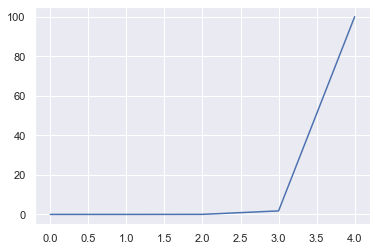

In [80]:
plt.plot(np.geomspace(1e-5,1e2,num=5))
np.geomspace(1e-5,1e2,num=5)

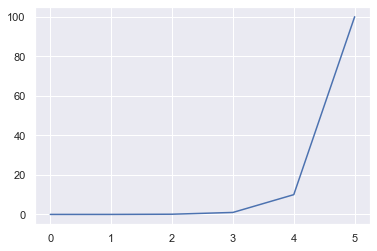

In [81]:

plt.plot([1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2])
#plt.plot(np.log)

In [ ]:
# fit model


# train and build the model
#tfidf = TfidfVectorizer()
#logreg = LogisticRegression(penalty='l2',solver='newton-cg')

from sklearn.model_selection import RepeatedStratifiedKFold


clf = Pipeline([('tfidf', TfidfVectorizer()), 
                ('logreg', LogisticRegression())])

param_grid = {#'tfidf__max_df':[0.1, 0.5, 1.0],
              #'tfidf__min_df':[0.1, 0.5, 1.0],
              'logreg__solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
              'logreg__C': np.geomspace(1e-5,1e2,num=5),
              'logreg__penalty': ['l2'],
              'logreg__multi_class': ['multinomial'],
              'logreg__max_iter':1000
             }
 
# L1 Regularization = Lasso Reg (“absolute value of magnitude”)
# L2 Regularization = Ridge reg ( “squared magnitude”)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

model = GridSearchCV(clf, param_grid=param_grid, 
                     cv=cv,  # specific metric or best_index_ o get_best_index
                     verbose=1, # the elapsed time and how long the model takes to run.
                     error_score=0,
                     n_jobs=-1) # specify how many cores we want to use on our CPU


#fit_logreg = clf.fit(X_train, y_train)
results = model.fit(X_train, y_train)

In [83]:
results.best_estimator_


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('logreg',
                 LogisticRegression(C=1.7782794100389228,
                                    multi_class='multinomial'))])

In [346]:
# Binarize the output
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer


X = dataset['review_lemma']
y = dataset['sentiment'] # Target level

# Binarize the output
lb = LabelBinarizer()
y = lb.fit_transform(y)
n_classes = len(lb.classes_) # y.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(clf,n_jobs=5)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#lb.inverse_transform(classifier.predict(['pero un poco malo']))
y_pred = classifier.predict(X_test)

# Crosstab between actual target values and predicted labels
confusion_matrix(lb.inverse_transform(y_test),lb.inverse_transform(y_pred))
(pd.crosstab(lb.inverse_transform(y_test),lb.inverse_transform(y_pred), rownames=['target'], colnames=['predicted']))

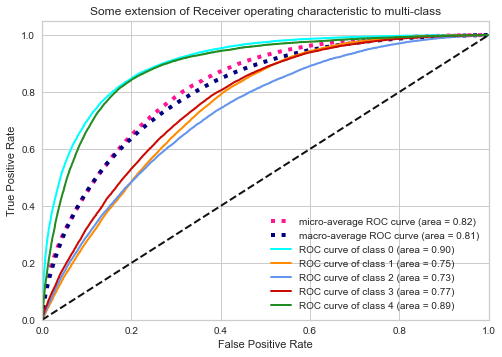

In [349]:
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'r', 'forestgreen'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [374]:
y_prob = classifier.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")

macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.752552 (macro),
0.808569 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.808588 (macro),
0.808569 (weighted by prevalence)


In [139]:
# predi X_test
y_pred = clf.predict(X_test)

In [1190]:
## cross val
#from sklearn.model_selection import cross_val_score
#tfidf_cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
#np.mean(tfidf_cv_scores)

In [145]:

model_evaluation(y_test, y_pred, X_train)
roc_curve(y_test, )

confusion matrix: 
 [[8853 2979  912  219  188]
 [3174 5534 3126  769  428]
 [1238 3399 5046 2583  939]
 [ 344 1020 2602 5114 4119]
 [ 269  454  791 2889 9011]]

accuracy:  0.5084545454545455

classification report: 
               precision    recall  f1-score   support

           1       0.64      0.67      0.66     13151
           2       0.41      0.42      0.42     13031
           3       0.40      0.38      0.39     13205
           4       0.44      0.39      0.41     13199
           5       0.61      0.67      0.64     13414

    accuracy                           0.51     66000
   macro avg       0.50      0.51      0.50     66000
weighted avg       0.50      0.51      0.50     66000



ValueError: multiclass format is not supported

In [1200]:
# predi X_test
y_pred = clf.predict(X_test)
#print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

In [1201]:
#  Crosstab between actual target values and predicted labels
(pd.crosstab(y_test,y_pred, rownames=['target'], colnames=['predicted']))

predicted,1,2,3,4,5
target,,,,,
1,8853,2979,912,219,188
2,3174,5534,3126,769,428
3,1238,3399,5046,2583,939
4,344,1020,2602,5114,4119
5,269,454,791,2889,9011


In [1202]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.64      0.67      0.66     13151
           2       0.41      0.42      0.42     13031
           3       0.40      0.38      0.39     13205
           4       0.44      0.39      0.41     13199
           5       0.61      0.67      0.64     13414

    accuracy                           0.51     66000
   macro avg       0.50      0.51      0.50     66000
weighted avg       0.50      0.51      0.50     66000



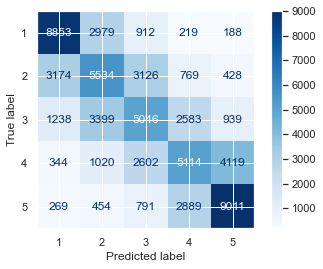

In [1209]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pi_log, X_test, y_test, cmap=plt.cm.Blues, values_format = '.0f');

<h3>Logistic Regression Binary</h3>    